#### Machine Learning

In [83]:
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, cross_val_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
#df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")
#df = pd.read_csv("../../data/exosomes.raw_spectrum_380-1800.csv")
#df = pd.read_csv("../../data/exosomes.raw_spectrum_400-1800.csv")
df = pd.read_csv("../../data/current_clean_spectrum.csv")

In [85]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,41.863303
1,201210-1-00,294,400.91116,201210-1,Normal,41.803843
2,201210-1-00,295,401.59454,201210-1,Normal,41.741884
3,201210-1-00,296,402.27789,201210-1,Normal,41.677722
4,201210-1-00,297,402.96127,201210-1,Normal,41.611654
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,12.378163
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,13.269937
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,14.199285
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,15.166531


**Remove Certain Wavenumber Intervals**

In [86]:
df = df[(df['WaveNumber'] >= 1100) | (df['WaveNumber'] <= 900)]
#df = df[(df['WaveNumber'] >= 450) & (df['WaveNumber'] <= 1600)]


In [87]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    # Include the SurID to perform GroupKFold CV
    statuses_and_surface = df[['SpecID', 'SurID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses_and_surface, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [88]:
def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # Getting cross-validation scores
    scores = cross_val_score(et, X, y, cv=cv, scoring='accuracy',groups=groups)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [89]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [90]:
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,41.863303,41.803843,41.741884,41.677722,41.611654,41.543974,41.474980,41.404968,41.334234,41.263073,...,6.280946,5.549559,4.745724,3.866578,2.909255,1.870891,0.748623,-0.460415,201210-1,Normal
201210-1-01,46.314608,47.323684,48.299209,49.241395,50.150457,51.026608,51.870063,52.681035,53.459738,54.206386,...,6.769011,7.280928,7.861246,8.512936,9.238972,10.042323,10.925962,11.892860,201210-1,Normal
201210-1-02,118.159018,114.686240,111.563911,108.777452,106.312282,104.153823,102.287493,100.698715,99.372907,98.295491,...,-4.633601,-4.557349,-4.439365,-4.278894,-4.075180,-3.827470,-3.535010,-3.197043,201210-1,Normal
201210-1-03,175.466997,174.846086,174.188020,173.498226,172.782129,172.045155,171.292728,170.530275,169.763222,168.996993,...,-10.801936,-10.349539,-9.864191,-9.347124,-8.799567,-8.222752,-7.617909,-6.986269,201210-1,Normal
201210-1-04,111.814973,106.629998,101.867380,97.512673,93.551430,89.969205,86.751551,83.884023,81.352173,79.141556,...,-11.689508,-11.752441,-11.789205,-11.799583,-11.783357,-11.740310,-11.670224,-11.572882,201210-1,Normal


Show the performance of the current approach.

In [91]:
evaluate_extra_trees(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5611 +/- 0.1047


Fit an Extra Trees Classifier on the whole dataset.

In [92]:
# Splitting the dataframe into features (X) and target variable (y)
X = wavelength_df.drop(['Status', 'SurID'], axis=1)
y = wavelength_df['Status']

et = ExtraTreesClassifier(random_state=1234)
et.fit(X, y)

ExtraTreesClassifier(random_state=1234)

In [93]:
feature_names = X.columns
importances = et.feature_importances_

# Creating a DataFrame from the feature names and importance
wavenumber_importance_df = pd.DataFrame({
    'WaveNumber': feature_names,
    'Importance': importances
})

wavenumber_importance_df

,WaveNumber,Importance
0,400.22778,0.000919
1,400.91116,0.000791
2,401.59454,0.000734
3,402.27789,0.000958
4,402.96127,0.000772
...,...,...
1752,1797.0387,0.000559
1753,1797.722,0.000840
1754,1798.4055,0.000359
1755,1799.0889,0.000422


In [94]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,41.863303
1,201210-1-00,294,400.91116,201210-1,Normal,41.803843
2,201210-1-00,295,401.59454,201210-1,Normal,41.741884
3,201210-1-00,296,402.27789,201210-1,Normal,41.677722
4,201210-1-00,297,402.96127,201210-1,Normal,41.611654
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,12.378163
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,13.269937
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,14.199285
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,15.166531


Seaborn was using different axes so I used Matplotlib instead.

Text(0.5, 1.0, 'Feature Importance and Average Spectra of each Status')

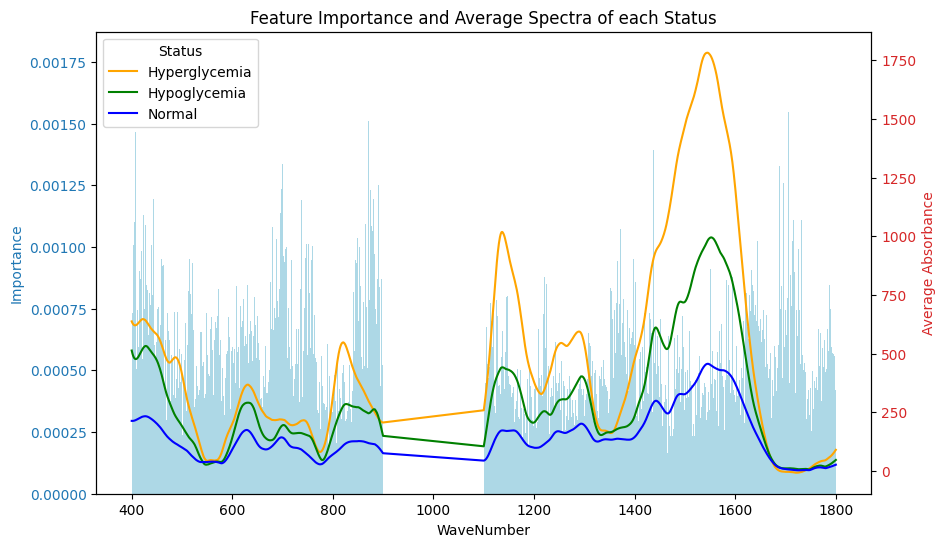

In [95]:
# Create the figure and the first (left) axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar plot on the first axis for Feature Importance
colors = ['lightblue'] * len(wavenumber_importance_df['WaveNumber'])
ax1.bar(wavenumber_importance_df['WaveNumber'], wavenumber_importance_df['Importance'], color=colors)
ax1.set_xlabel('WaveNumber')
ax1.set_ylabel('Importance', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second (right) axis, sharing the same x-axis
ax2 = ax1.twinx()

# Calculate average absorbance by WaveNumber and Status
avg_absorbance = df.groupby(['WaveNumber', 'Status'])['Absorbance'].mean().reset_index()

# Color mapping for 'Status'
color_map = {'Normal': 'blue', 'Hyperglycemia': 'orange', 'Hypoglycemia': 'green'}

# Plot average absorbance line plot on the second axis for each status
for status, group in avg_absorbance.groupby('Status'):
    ax2.plot(group['WaveNumber'], group['Absorbance'], label=status, color=color_map[status])

ax2.set_ylabel('Average Absorbance', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legend for the line plots to distinguish between statuses
ax2.legend(title='Status')

# Title for the entire plot
plt.title('Feature Importance and Average Spectra of each Status')

# # Show the plot
# plt.tight_layout()
# plt.show()

#### **Cross-Val Importance**

Training the model on the whole dataset may be misleading, lets look at the average feature importance of each WaveNumber across the 10 folds.

In [96]:
groups = wavelength_df['SurID']
X = wavelength_df.drop(['Status', 'SurID'], axis=1)
y = wavelength_df['Status']

# Creating the Extra Trees classifier
et = ExtraTreesClassifier(random_state=1234)

# Using GroupKFold for classification tasks
cv = GroupKFold(n_splits=10)

# Initialising an array to store feature importances across all folds
feature_importances = np.zeros(X.shape[1])

# Looping through each split, correctly using the groups
for train_index, test_index in cv.split(X, y, groups=groups):
    
    # Splitting the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fitting the Extra Trees classifier
    et.fit(X_train, y_train)
    
    # Accumulating the feature importances
    feature_importances += et.feature_importances_

# Averaging the feature importances across all folds
feature_importances /= cv.get_n_splits()

# Creating a DataFrame from the feature names and their average importance
feature_names = X.columns
wavenumber_importance_df = pd.DataFrame({
    'WaveNumber': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

wavenumber_importance_df

,WaveNumber,Importance
689,871.07062,0.001426
1123,1367.1981,0.001360
432,695.44421,0.001340
704,881.32117,0.001300
449,707.06152,0.001292
...,...,...
863,1189.5216,0.000249
855,1184.0547,0.000245
1684,1750.5695,0.000244
853,1182.6879,0.000234


Text(0.5, 1.0, 'Feature Importance and Average Spectra of each Status')

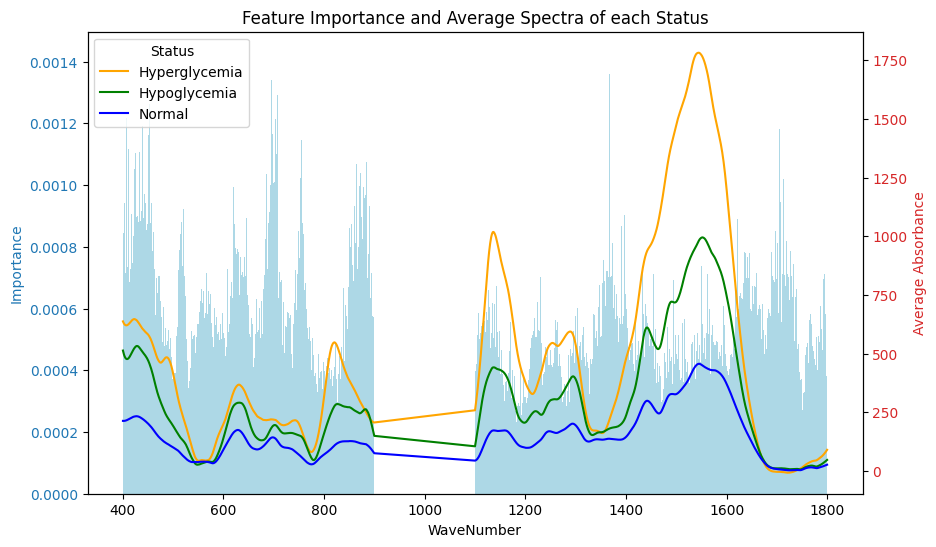

In [97]:
# Create the figure and the first (left) axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar plot on the first axis for Feature Importance
colors = ['lightblue'] * len(wavenumber_importance_df['WaveNumber'])
ax1.bar(wavenumber_importance_df['WaveNumber'], wavenumber_importance_df['Importance'], color=colors)
ax1.set_xlabel('WaveNumber')
ax1.set_ylabel('Importance', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second (right) axis, sharing the same x-axis
ax2 = ax1.twinx()

# Calculate average absorbance by WaveNumber and Status
avg_absorbance = df.groupby(['WaveNumber', 'Status'])['Absorbance'].mean().reset_index()

# Color mapping for 'Status'
color_map = {'Normal': 'blue', 'Hyperglycemia': 'orange', 'Hypoglycemia': 'green'}

# Plot average absorbance line plot on the second axis for each status
for status, group in avg_absorbance.groupby('Status'):
    ax2.plot(group['WaveNumber'], group['Absorbance'], label=status, color=color_map[status])

ax2.set_ylabel('Average Absorbance', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legend for the line plots to distinguish between statuses
ax2.legend(title='Status')

# Title for the entire plot
plt.title('Feature Importance and Average Spectra of each Status')

# # Show the plot
# plt.tight_layout()
# plt.show()